In [11]:
import sys
sys.path.append("..")
import torch
from iastar_v3 import iastar
from dastar import dastar
import matplotlib.pyplot as plt
from data_loader import create_dataloader
from utils import  visualize_results
from neural_astar.utils.training import load_from_ptl_checkpoint

from neural_astar.planner import NeuralAstar

device = "cuda" if torch.cuda.is_available() else "cpu"
neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/nastar/mazes_032_moore_c8/lightning_logs/"))

def load_from_ptl_checkpoint(filename):
    return torch.load(filename)["model_state_dict"]
ia_planner = iastar(encoder_input=3,
                    encoder_arch="UNetAtt",
                    device=device,
                    encoder_depth=4,
                    learn_obstacles=False,
                    is_training = False,
                    output_path_list= False,
                    w=1.0).to(device)
ia_planner.encoder.load_state_dict(load_from_ptl_checkpoint("/home/cxy/iAstar/model/02-09-2024-15-18-38/42/iaster1UNetAtt.pkl"))
da_planner = dastar()


load ../model/nastar/mazes_032_moore_c8/lightning_logs/version_0/checkpoints/epoch=33-step=272.ckpt
Using %s as encoder UNet


Number of Train Samples: 3200
	Size: 64x64
dastar finished.
nastar finished.
iastar finished.


(-0.5, 529.5, 67.5, -0.5)

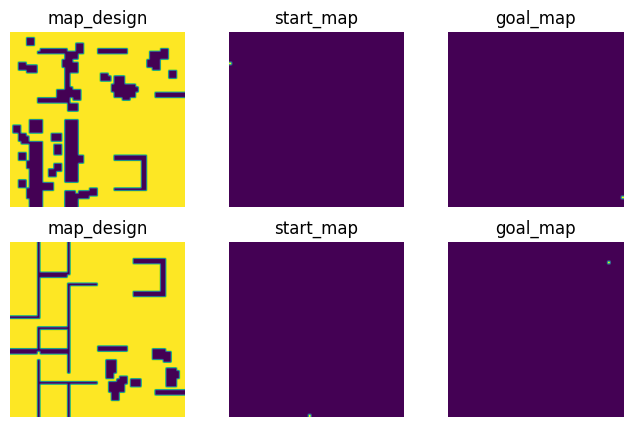

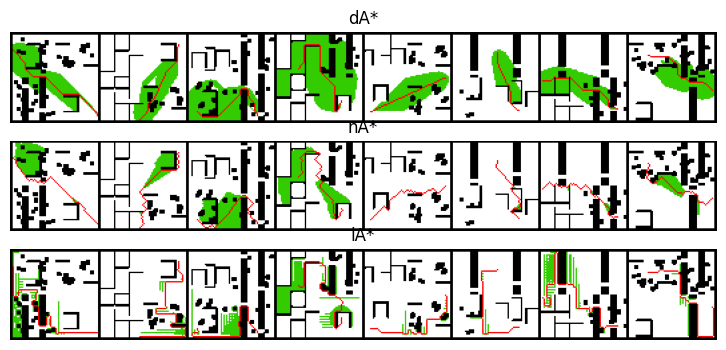

In [12]:
dataloader = create_dataloader("/home/cxy/iAstar/planning-datasets/mpd/instances/064/all_064_moore_c16.npz", "train", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs= da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs= ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")
# axes[2].imshow(i_g[4].detach().cpu().numpy())
# axes[2].set_title("iA*")
# axes[2].axis("off")

In [7]:
torch.sum(ia_outputs.histories - ia_outputs.paths)
import torch.nn as nn
import torch.nn.functional as F
def getLoss(outputs):
    paths = outputs.paths
    path_kernel = torch.tensor([[[1.414,1.,1.414,],
                    [1.,0.,1.],
                    [1.414, 1.,1.414]]],
                device = paths.device,
                requires_grad=True).expand(1,1, 3, 3)
    area_loss = torch.sum(outputs.histories - outputs.paths)/paths.shape[0]
    print(area_loss)
    pad = nn.ReplicationPad2d(padding=(1,1,1,1))
    pad = nn.ZeroPad2d(padding=(1,1,1,1)).to(paths.device)
    path_length = F.conv2d(pad(paths).float(), path_kernel)
    length_loss = torch.sum(path_length*paths)/2/paths.shape[0]
    return torch.sqrt(area_loss), length_loss
getLoss(na_outputs)

tensor(17.6250, device='cuda:0', grad_fn=<DivBackward0>)


(tensor(4.1982, device='cuda:0', grad_fn=<SqrtBackward0>),
 tensor(35.5428, device='cuda:0', grad_fn=<DivBackward0>))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

def CostofTraj(maps, outputs):
    path_kernel = torch.tensor([[[1.414,1.,1.414,],
                    [1.,0.,1.],
                    [1.414, 1.,1.414]]],
                device = device,
                requires_grad=True).expand(1,1, 3, 3)
    paths = outputs.paths
    area_loss = torch.sum(outputs.histories - outputs.paths)/maps.shape[0]
    pad = nn.ReplicationPad2d(padding=(1,1,1,1))
    pad = nn.ZeroPad2d(padding=(1,1,1,1)).to(device)
    path_length = F.conv2d(pad(paths).float(), path_kernel)
    length_loss = torch.sum(path_length*paths)/(2*maps.shape[0])
    print(area_loss, length_loss)
    return torch.sqrt(area_loss) + length_loss
CostofTraj(map_designs,ia_outputs)

tensor(28.8750, device='cuda:0', grad_fn=<DivBackward0>) tensor(33.2832, device='cuda:0', grad_fn=<DivBackward0>)


tensor(38.6568, device='cuda:0', grad_fn=<AddBackward0>)

Number of Test Samples: 5
	Size: 64x64


dastar finished.
nastar finished.
iastar finished.


(-0.5, 331.5, 67.5, -0.5)

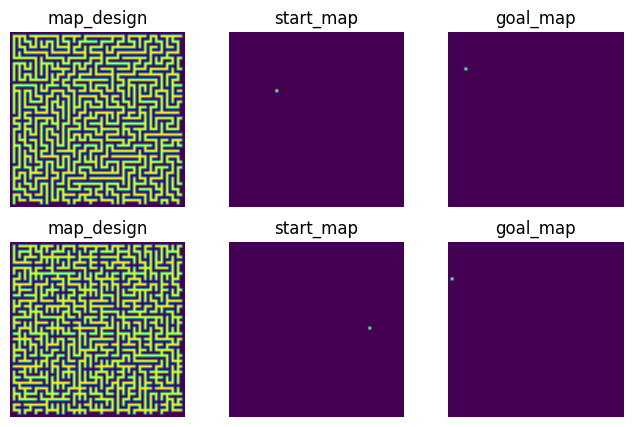

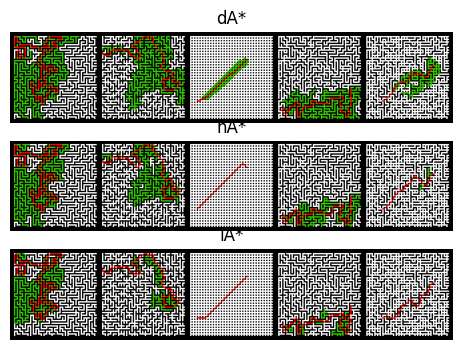

In [7]:
dataloader = create_dataloader("../planning-datasets/maze/instances/064/maze_064_moore_c16.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs = da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs = ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")

Number of Train Samples: 14
	Size: 64x64
dastar finished.
nastar finished.
iastar finished.


(-0.5, 529.5, 67.5, -0.5)

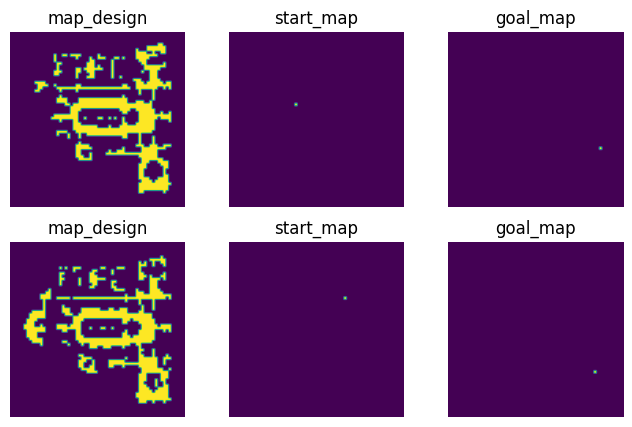

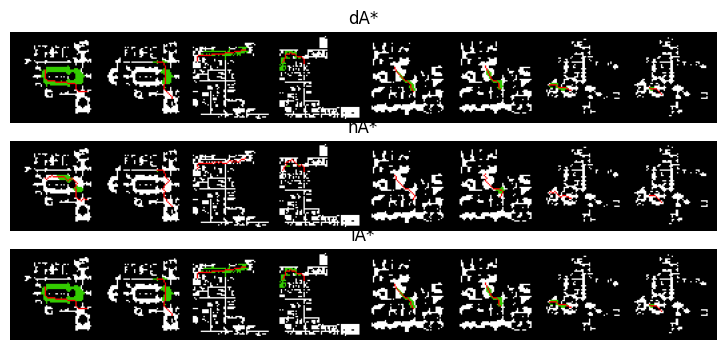

In [5]:
dataloader = create_dataloader("../planning-datasets/matterport/instances/064/tsdf_064_moore_c25.npz", "train", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))
fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")
da_planner.eval()
da_outputs = da_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("dastar finished.")
da_planner.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("nastar finished.")
ia_planner.eval()
ia_outputs = ia_planner(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
print("iastar finished.")
fig, axes = plt.subplots(3, 1, figsize=[12, 4])

axes[0].imshow(visualize_results(map_designs, da_outputs))
axes[0].set_title("dA*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, na_outputs))
axes[1].set_title("nA*")
axes[1].axis("off")
axes[2].imshow(visualize_results(map_designs, ia_outputs))
axes[2].set_title("iA*")
axes[2].axis("off")

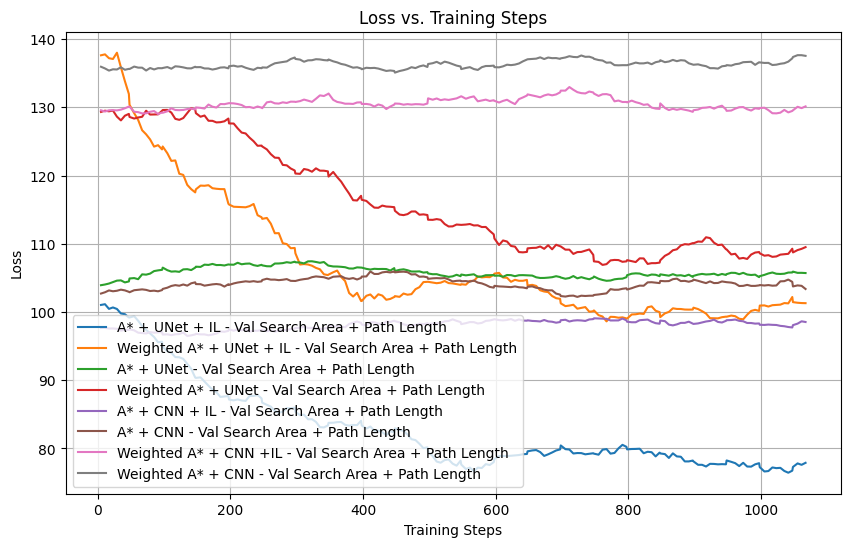

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 步骤1: 读取CSV数据
file_path = './valloss.csv' # 请替换为你的CSV文件实际路径
data = pd.read_csv(file_path)

# 步骤2: 数据预处理 —— 假设CSV文件的列已正确设置，无需额外处理

# 步骤3 & 4: 画图和平滑曲线
def plot_smoothed_loss(data, window_size=50):
    plt.figure(figsize=(10, 6))
    steps = data['Step']  # 训练步骤
    
    for column in data.columns:
        if column != 'Step':
            # 计算移动平均来平滑曲线
            values = data[column]
            smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
            # 画出平滑后的曲线
            plt.plot(steps[:len(smoothed_values)], smoothed_values, label=column)

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss vs. Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行画图函数
plot_smoothed_loss(data)

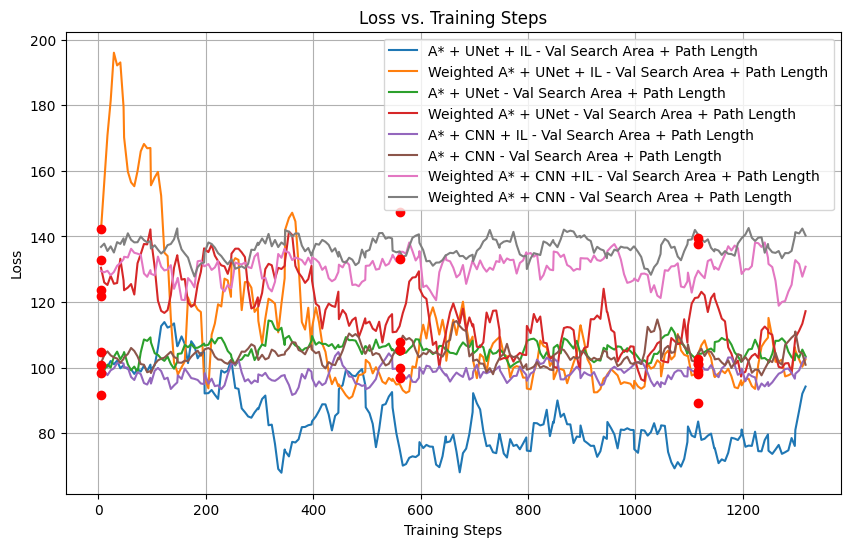

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 步骤1: 读取CSV数据
file_path = './valloss.csv'# 请替换为你的CSV文件实际路径
data = pd.read_csv(file_path)

# 步骤2: 数据预处理 —— 假设CSV文件的列已正确设置，无需额外处理

# 步骤3 & 4: 画图和平滑曲线
def plot_smoothed_loss(data, window_size=5):
    plt.figure(figsize=(10, 6))
    steps = data['Step']  # 训练步骤
    
    for column in data.columns:
        if column != 'Step':
            # 计算移动平均来平滑曲线
            values = data[column]
            smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
            
            # 画出平滑后的曲线
            plt.plot(steps[:len(smoothed_values)], smoothed_values, label=column)

            # 突出每100步的数据点
            if len(steps) >= 10:  # 确保数据足够
                indices = np.arange(0, len(steps), 100)
                plt.scatter(steps[indices], values[indices], color='red', zorder=5)

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss vs. Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行画图函数
plot_smoothed_loss(data)

0          0
1          1
2          2
3          3
4          4
        ... 
1675    2092
1676    2093
1677    2094
1678    2095
1679    2096
Name: Step, Length: 1680, dtype: int64


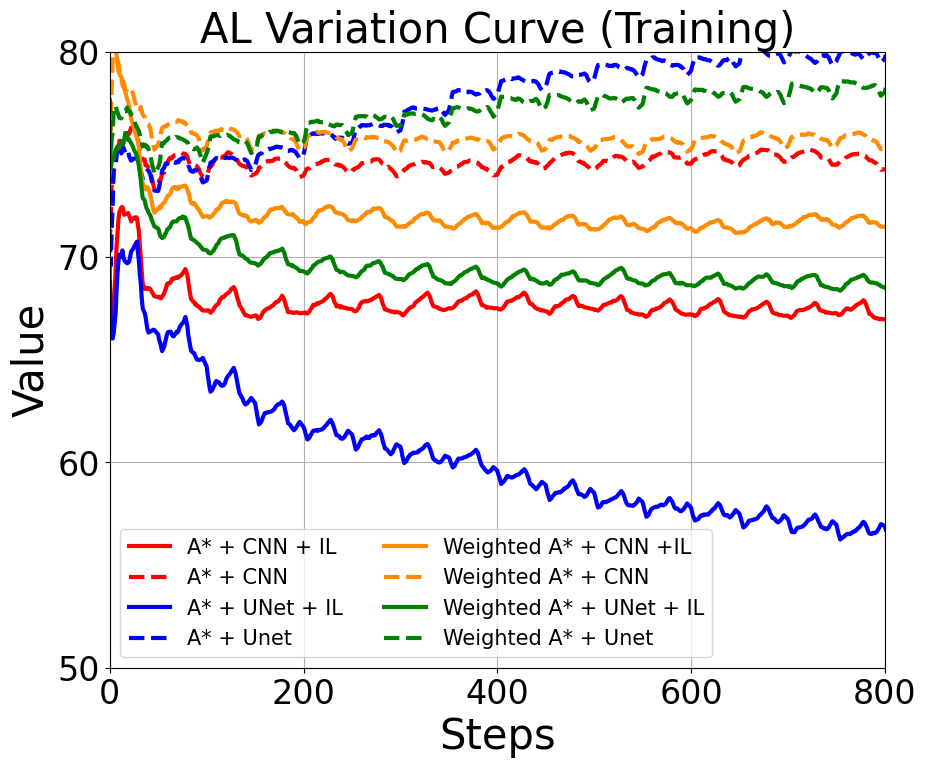

In [65]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# 步骤1: 读取CSV数据
file_path = './trainloss.csv'  # 请替换为你的CSV文件实际路径
df = pd.read_csv(file_path)
data = df.sort_index(axis=0)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# 步骤2: 数据预处理
# 确保数据格式合适，假设有 'Step' 列和其他方法的损失列
color = {"A* + CNN + IL":"red",
         "A* + CNN":"red",
         "A* + UNet + IL":"blue",
         "A* + Unet":"blue",
         "Weighted A* + CNN +IL":"darkorange",	
         "Weighted A* + CNN":"darkorange",
         "Weighted A* + UNet + IL":"green",
         "Weighted A* + Unet":"green"}

# 步骤3 & 4: 画图和使用时间加权 EMA
def plot_ema_loss(data, span=200):
    plt.figure(figsize=(10, 8))
    steps = data['Step']# 训练步骤
    print(steps)
    for column in color.keys():
        if column != 'Step':
            # 计算时间加权 EMA
            ema_values = data[column].ewm(span=span, adjust=True).mean()
            if "IL" not in column:
            # 画出时间加权 EMA 曲线
                plt.plot(steps, ema_values, label=f'{column}', linestyle='--', linewidth = 3, c = color[column])
            else:
                plt.plot(steps, ema_values, label=f'{column}',  linewidth = 3,c = color[column])
            
    plt.axis([0, 800, 50, 80])
    plt.xlabel('Steps',fontsize = 30)
    plt.ylabel('Value',fontsize = 30)
    plt.xticks(np.arange(0, 801, 200), fontsize=24)
    plt.yticks(np.arange(50, 81, 10), fontsize=24)
    plt.title('AL Variation Curve (Training)', fontsize = 30)
    plt.legend(fontsize = 15, ncol=2)
    plt.grid(True)
    plt.savefig('ALCurve(train).pdf')
    plt.show()
    

# 执行画图函数
plot_ema_loss(data)

0         1
1         5
2        11
3        17
4        23
       ... 
237    1317
238    1323
239    1329
240    1335
241    1341
Name: Step, Length: 242, dtype: int64


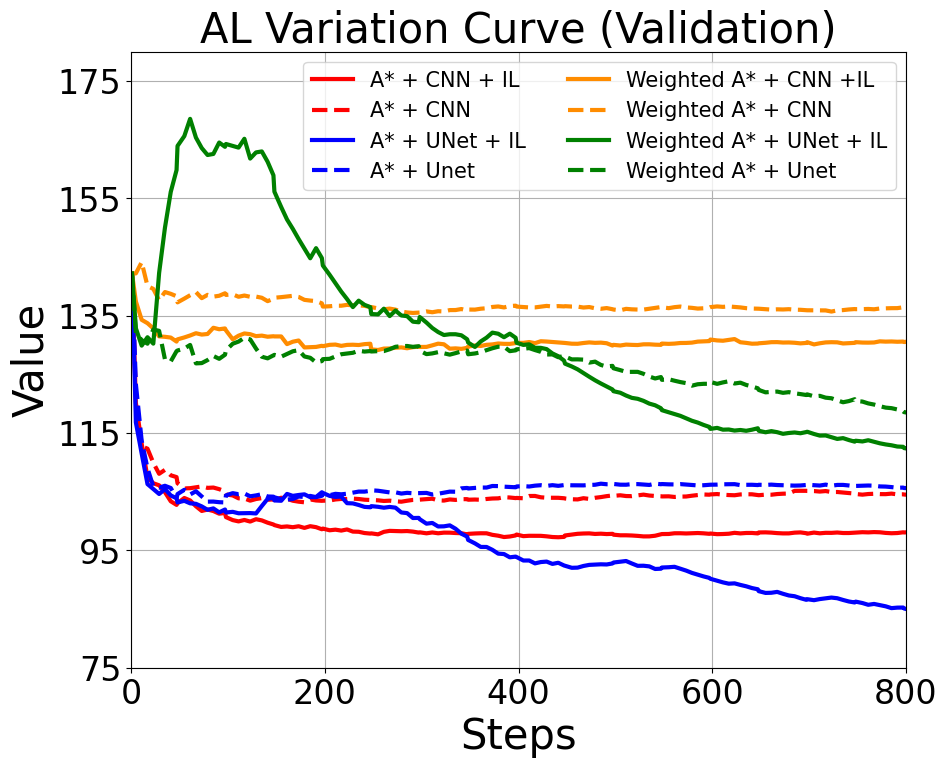

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# 步骤1: 读取CSV数据
file_path = 'valloss.csv'  # 请替换为你的CSV文件实际路径
df = pd.read_csv(file_path)
data = df.sort_index(axis=1)

# 步骤2: 数据预处理
# 确保数据格式合适，假设有 'Step' 列和其他方法的损失列
color = {"A* + CNN + IL":"red",
         "A* + CNN":"red",
         "A* + UNet + IL":"blue",
         "A* + Unet":"blue",
         "Weighted A* + CNN +IL":"darkorange",	
         "Weighted A* + CNN":"darkorange",
         "Weighted A* + UNet + IL":"green",
         "Weighted A* + Unet":"green"}

# 步骤3 & 4: 画图和使用时间加权 EMA
def plot_ema_loss(data, span=200):
    plt.figure(figsize=(10, 8))
    steps = data['Step']# 训练步骤
    print(steps)
    for column in color.keys():
        if column != 'Step':
            # 计算时间加权 EMA
            ema_values = data[column].ewm(span=span, adjust=True).mean()
            if "IL" not in column:
            # 画出时间加权 EMA 曲线
                plt.plot(steps, ema_values, label=f'{column}', linestyle='--', linewidth = 3, c = color[column])
            else:
                plt.plot(steps, ema_values, label=f'{column}',  linewidth = 3,c = color[column])
            
    plt.axis([0, 800, 75, 180])
    plt.xlabel('Steps',fontsize = 30)
    plt.ylabel('Value',fontsize = 30)
    plt.xticks(np.arange(0, 801, 200), fontsize=24)
    plt.yticks(np.arange(75, 176, 20), fontsize=24)
    plt.title('AL Variation Curve (Validation)', fontsize = 30)
    plt.legend(fontsize = 15, ncol = 2)
    plt.grid(True)
    plt.savefig('ALCurve(val).pdf')
    plt.show()
    
# 执行画图函数
plot_ema_loss(data)

In [10]:
import torch
model_file = "/home/cxy/SAIRLAB/iAstar/models/version_0/checkpoints/epoch=0-step=32.ckpt"
ia_planner = iastar(encoder_input=3,
                    encoder_arch="UNet",
                    device=device,
                    encoder_depth=4,
                    learn_obstacles=False,
                    is_training = False,
                    output_path_list= False,
                    w=1.0)
model = ia_planner.encoder# calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

Using %s as encoder UNet
31037633


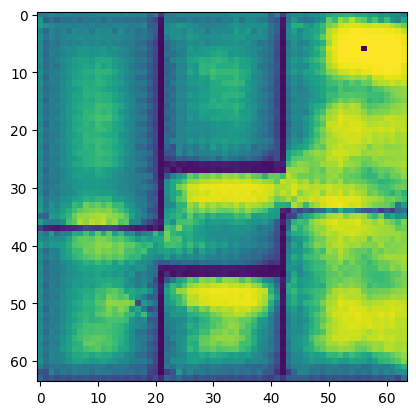

In [6]:
a = ia_planner.encoder(torch.cat((map_designs.to(device), start_maps.to(device), goal_maps.to(device)), dim=1))
plt.imshow(a[0, 0].detach().cpu().numpy())

In [7]:
print(torch.max(a))

tensor(63.9999, device='cuda:0', grad_fn=<MaxBackward1>)


In [8]:
print(torch.min(a))

tensor(4.8049e-05, device='cuda:0', grad_fn=<MinBackward1>)
